## Cell 1: Load and Analyze Double-Slit Scattering Data from Excel
This cell loads the Excel file with different sheets (each corresponding to a scattering angle), defines a function to detect peaks and calculate fringe spacing, plots the interference pattern, and stores the fringe spacing results.

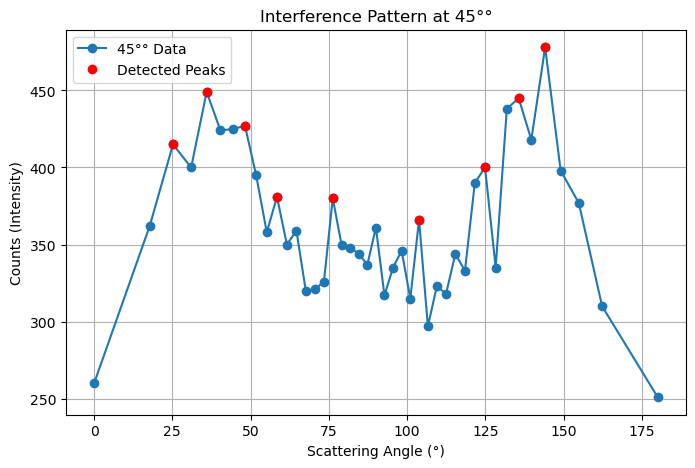

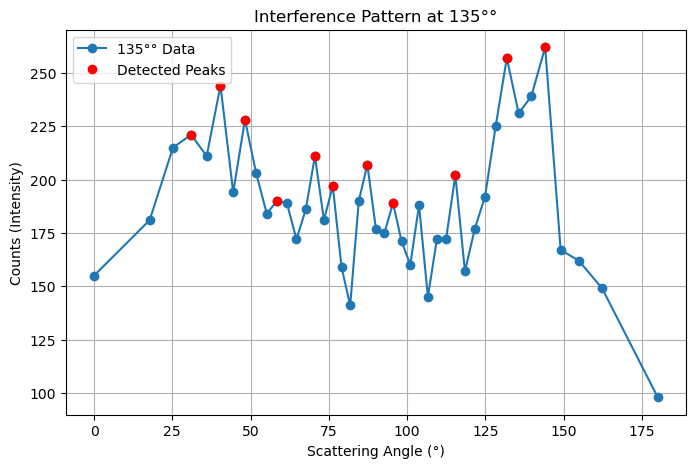

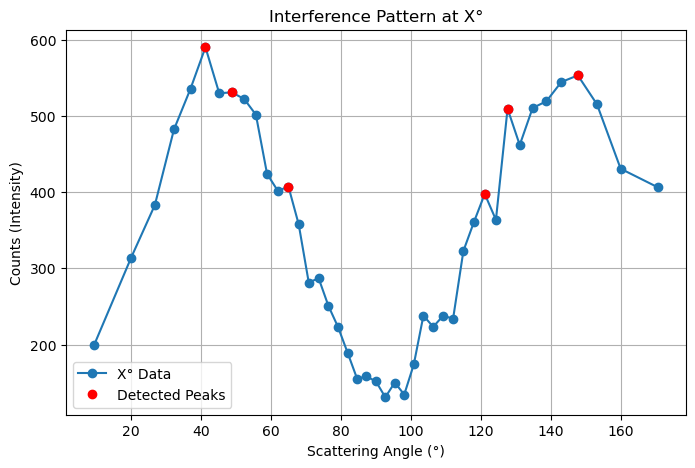


Fringe Spacing Results:
Angle 45°°: 14.855 ± 6.241 degrees
Angle 135°°: 11.305 ± 4.002 degrees
Angle X°: 21.292 ± 18.148 degrees


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ------------------------------
# File and Data Loading Section
# ------------------------------

# Updated file path (ensure this path is correct on your computer)
excel_file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Science Projects\Double Slit\TimeDrivenQuantumCollapse\data\Data_D2He_DoubleSlitScattering.xlsx"

# Check if file exists before proceeding
if not os.path.exists(excel_file_path):
    raise FileNotFoundError(f"File not found: {excel_file_path}")

try:
    xl = pd.ExcelFile(excel_file_path)
except Exception as e:
    raise IOError(f"Error loading Excel file: {e}")

# Retrieve sheet names (each representing a scattering angle)
angles = xl.sheet_names

# Parse all sheets into a dictionary
data_dict = {}
for angle in angles:
    try:
        data = xl.parse(angle)
        data_dict[angle] = data
    except Exception as e:
        print(f"Error parsing sheet {angle}: {e}")

# -------------------------------------------------
# Function: Analyze Interference Pattern & Spacing
# -------------------------------------------------

def analyze_fringe_spacing(data, angle, save_plot=False, plot_dir="plots"):
    """
    Detect peaks in the double-slit experiment data and calculate fringe spacing.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the experiment data.
        angle (str): Label for the current dataset (scattering angle).
        save_plot (bool): Whether to save the generated plot as an image.
        plot_dir (str): Directory where to save the plot if save_plot is True.
        
    Returns:
        np.array: Array of fringe spacings (differences in degrees between detected peaks).
    """
    # Use named columns if available; otherwise, assume the first two columns
    if 'Scattering Angle' in data.columns and 'Counts' in data.columns:
        x = data['Scattering Angle']
        y = data['Counts']
    else:
        x = data.iloc[:, 0]
        y = data.iloc[:, 1]
    
    # Detect peaks with a height threshold (mean) and a minimum prominence to reduce noise
    height_threshold = np.mean(y)
    peaks, _ = find_peaks(y, height=height_threshold, prominence=0.5)
    
    if len(peaks) < 2:
        print(f"Not enough peaks detected for angle {angle}.")
        return np.array([])
    
    fringe_spacing = np.diff(x.iloc[peaks])  # Compute differences between consecutive peak positions
    
    # Plot data with detected peaks
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, label=f"{angle}° Data", marker="o", linestyle="-")
    plt.plot(x.iloc[peaks], y.iloc[peaks], "ro", label="Detected Peaks")
    plt.xlabel("Scattering Angle (°)")
    plt.ylabel("Counts (Intensity)")
    plt.title(f"Interference Pattern at {angle}°")
    plt.legend()
    plt.grid(True)
    
    if save_plot:
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
        plot_filename = os.path.join(plot_dir, f"interference_pattern_{angle}.png")
        plt.savefig(plot_filename, dpi=300)
        print(f"Plot saved to {plot_filename}")
    else:
        plt.show()
    
    plt.close()  # Free memory
    return fringe_spacing

# -----------------------------------------------
# Analyze all sheets and print fringe spacing stats
# -----------------------------------------------
fringe_spacing_results = {}
for angle, data in data_dict.items():
    spacing = analyze_fringe_spacing(data, angle)
    fringe_spacing_results[angle] = spacing

print("\nFringe Spacing Results:")
for angle, spacing in fringe_spacing_results.items():
    if spacing.size > 0:
        mean_spacing = spacing.mean()
        std_spacing = spacing.std()
        print(f"Angle {angle}°: {mean_spacing:.3f} ± {std_spacing:.3f} degrees")
    else:
        print(f"Angle {angle}°: Not enough peaks detected to compute fringe spacing.")


## Cell 2: Quantum Coherence Decay Analysis
This cell loads the quantum coherence CSV data, cleans up the header issues, fits an exponential decay model to the coherence amplitude, plots the experimental data with the fitted curve, and prints the fitted collapse rate.

C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


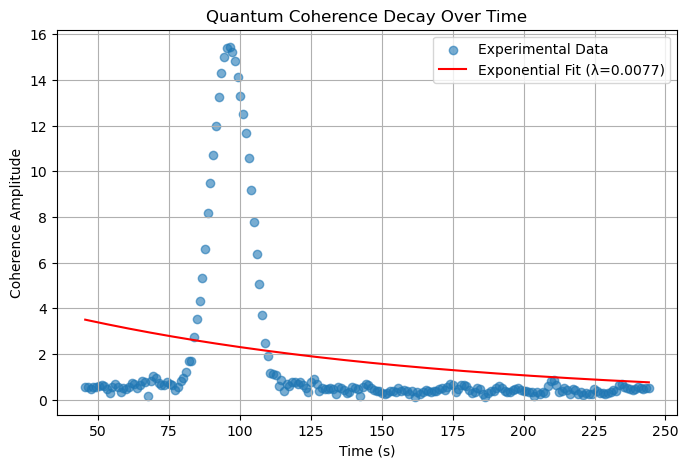

Fitted Collapse Rate (λ): 0.007689 per second


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ------------------------------
# Load and Clean Quantum Coherence Data
# ------------------------------
coherence_file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Science Projects\Double Slit\TimeDrivenQuantumCollapse\data\Fig3_panel_a.csv"
df_coherence = pd.read_csv(coherence_file_path)

# Assume the first row contains header labels (reset index accordingly)
df_coherence.columns = df_coherence.iloc[0]
df_coherence = df_coherence[1:].reset_index(drop=True)
df_coherence = df_coherence.apply(pd.to_numeric, errors='coerce')
df_coherence.dropna(inplace=True)

# Extract time and coherence amplitude (adjust indices if necessary)
time = df_coherence.iloc[:, 0]      # Time (s)
coherence = df_coherence.iloc[:, 1]  # FFT amplitude (mV)

# ------------------------------
# Fit Exponential Decay to Coherence Data
# ------------------------------

def exponential_decay(t, lambda_collapse, A):
    return A * np.exp(-lambda_collapse * t)

# Initial guess: lambda=0.1 and amplitude = max(coherence)
params, covariance = curve_fit(exponential_decay, time, coherence, p0=[0.1, max(coherence)])
lambda_fit, A_fit = params

# Generate fitted curve
fit_curve = exponential_decay(time, lambda_fit, A_fit)

# Plot experimental data with the exponential fit
plt.figure(figsize=(8, 5))
plt.scatter(time, coherence, label="Experimental Data", alpha=0.6)
plt.plot(time, fit_curve, color='red', label=f"Exponential Fit (λ={lambda_fit:.4f})")
plt.xlabel("Time (s)")
plt.ylabel("Coherence Amplitude")
plt.title("Quantum Coherence Decay Over Time")
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted Collapse Rate (λ): {lambda_fit:.6f} per second")



## Cell 3: Simulated Double-Slit Interference Pattern Analysis
This cell loads the simulated double-slit data (CSV), sorts the data by position, detects interference peaks, calculates fringe spacing, and plots the interference pattern.



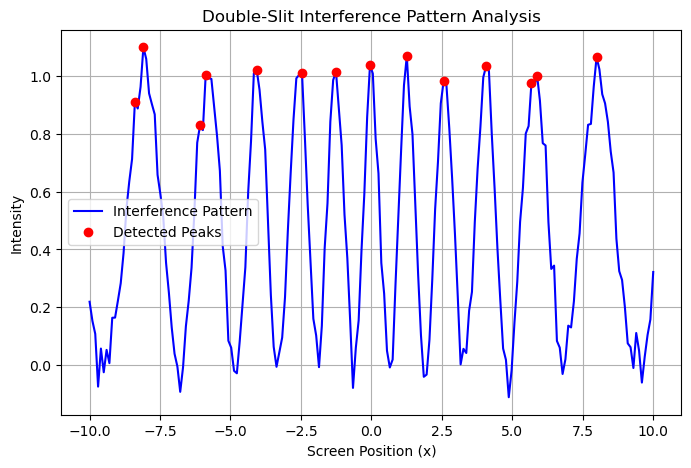

Average Fringe Spacing: 1.260 ± 0.624


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ------------------------------
# Load Simulated Double-Slit Data
# ------------------------------
simulated_file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Science Projects\Double Slit\TimeDrivenQuantumCollapse\data\simulated_double_slit_data.csv"
df_simulated = pd.read_csv(simulated_file_path)

# Sort data by screen position and extract x (position) and y (intensity)
df_simulated = df_simulated.sort_values(by="Position (x)")
x = df_simulated["Position (x)"].values
y = df_simulated["Intensity"].values

# ------------------------------
# Detect Peaks and Calculate Fringe Spacing
# ------------------------------
peaks, _ = find_peaks(y, height=np.mean(y))
if len(peaks) >= 2:
    fringe_spacing = np.diff(x[peaks])
else:
    fringe_spacing = np.array([])

# Plot interference pattern with detected peaks
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Interference Pattern", color="blue")
plt.plot(x[peaks], y[peaks], "ro", label="Detected Peaks")
plt.xlabel("Screen Position (x)")
plt.ylabel("Intensity")
plt.title("Double-Slit Interference Pattern Analysis")
plt.legend()
plt.grid(True)
plt.show()

if fringe_spacing.size > 0:
    print(f"Average Fringe Spacing: {np.mean(fringe_spacing):.3f} ± {np.std(fringe_spacing):.3f}")
else:
    print("Not enough peaks detected to compute fringe spacing.")




## Cell 4: Extended Analysis – Fringe Spacing vs. de Broglie Wavelength and Log(Mass)
This cell uses the previously loaded simulated data and computes theoretical de Broglie wavelengths for an extended range of particle masses. It then plots fringe spacing versus de Broglie wavelength and versus the log of particle masses.

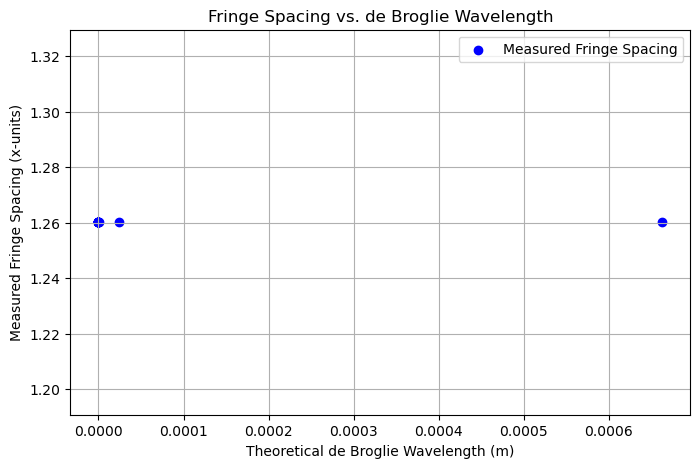

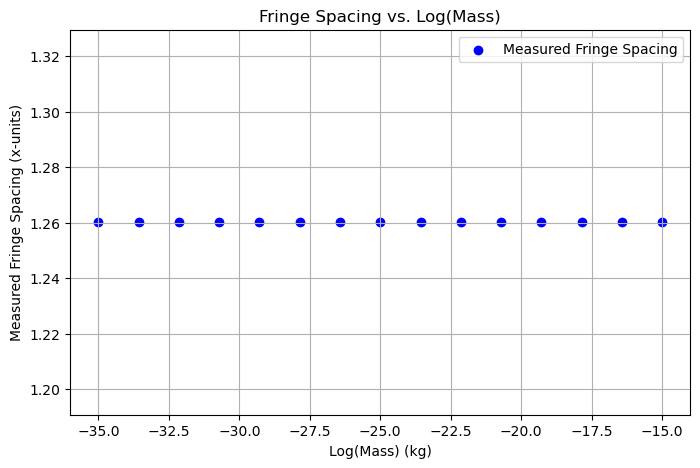

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Constants and Theoretical Calculations
# ------------------------------
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5        # Assumed particle velocity (m/s)

# Define an extended range of particle masses (kg)
particle_masses = np.logspace(-35, -15, num=15)  # 15 log-spaced mass values
debroglie_wavelengths = [h / (m * v) for m in particle_masses]

# ------------------------------
# Plot: Fringe Spacing vs. de Broglie Wavelength
# ------------------------------
plt.figure(figsize=(8, 5))
# Use the mean fringe spacing from simulated data (if available)
if fringe_spacing.size > 0:
    mean_fringe = np.mean(fringe_spacing)
    plt.scatter(debroglie_wavelengths, [mean_fringe] * len(debroglie_wavelengths), 
                label="Measured Fringe Spacing", color="blue")
    plt.xlabel("Theoretical de Broglie Wavelength (m)")
    plt.ylabel("Measured Fringe Spacing (x-units)")
    plt.title("Fringe Spacing vs. de Broglie Wavelength")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Cannot plot fringe spacing vs. de Broglie wavelength (insufficient data).")

# ------------------------------
# Plot: Fringe Spacing vs. Log(Mass)
# ------------------------------
plt.figure(figsize=(8, 5))
if fringe_spacing.size > 0:
    plt.scatter(np.log10(particle_masses), [mean_fringe] * len(particle_masses), 
                label="Measured Fringe Spacing", color="blue")
    plt.xlabel("Log(Mass) (kg)")
    plt.ylabel("Measured Fringe Spacing (x-units)")
    plt.title("Fringe Spacing vs. Log(Mass)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Cannot plot fringe spacing vs. log(mass) (insufficient data).")



## Cell 5: Extended Analysis – Fringe Spacing & Visibility Decay Over Time
This cell simulates the decay of fringe spacing (using an exponential model with your fitted collapse rate) and fringe visibility over time. It also compares the simulated visibility decay with a standard quantum decoherence model.


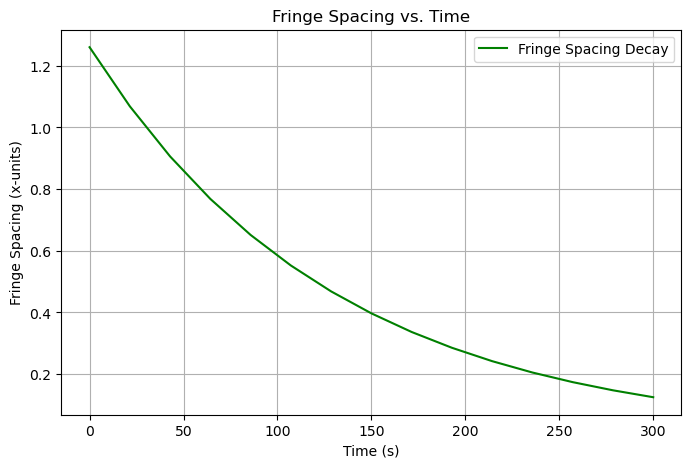

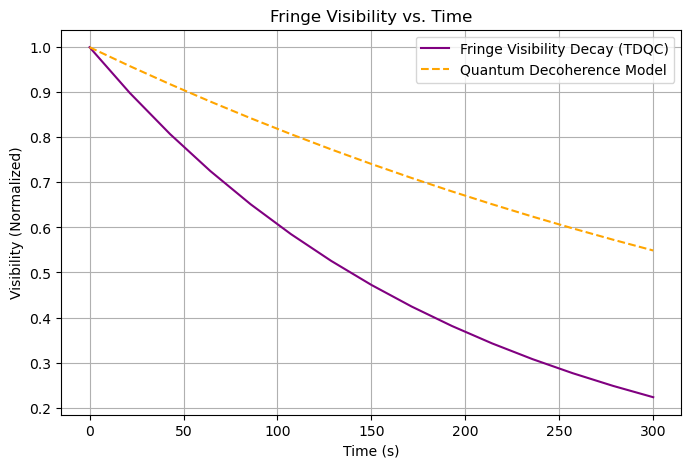

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Simulation Parameters
# ------------------------------
# Use the mean fringe spacing from the simulated data (if available)
if fringe_spacing.size > 0:
    mean_fringe = np.mean(fringe_spacing)
else:
    mean_fringe = 1.0  # default value if data not available

# Collapse rate (λ) from coherence analysis (or use a predefined value)
lambda_collapse = 0.0077  

# Time range for simulation (0 to 300 seconds)
time_values = np.linspace(0, 300, num=15)

# Simulate fringe spacing decay over time (exponential decay)
fringe_spacing_over_time = mean_fringe * np.exp(-lambda_collapse * time_values)

# Simulate fringe visibility (contrast) decay over time (using a hypothetical decay rate)
fringe_visibility_over_time = np.exp(-0.005 * time_values)

# Standard quantum decoherence model for comparison (using another decay rate)
decoherence_model = np.exp(-0.002 * time_values)

# ------------------------------
# Plot: Fringe Spacing Decay Over Time
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(time_values, fringe_spacing_over_time, label="Fringe Spacing Decay", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Time")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Plot: Fringe Visibility vs. Time
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(time_values, fringe_visibility_over_time, label="Fringe Visibility Decay (TDQC)", color="purple")
plt.plot(time_values, decoherence_model, label="Quantum Decoherence Model", color="orange", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Visibility (Normalized)")
plt.title("Fringe Visibility vs. Time")
plt.legend()
plt.grid(True)
plt.show()



## Cell 6: Machine Learning – Linear Regression Prediction of Fringe Spacing Over Time
This cell uses the simulated decay data (fringe spacing over time) to train a linear regression model. It then evaluates the model performance and plots the actual versus predicted fringe spacing.

Linear Regression Model Results:
Mean Squared Error (MSE): 0.030244
R-squared (R2) Score: 0.868469


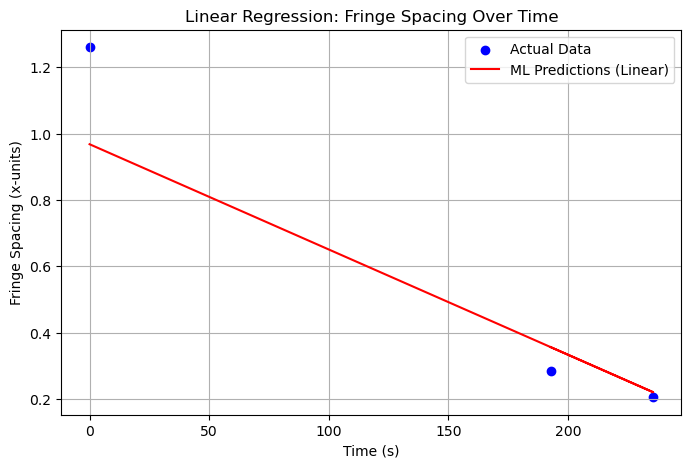

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------
# Prepare Data for ML (Linear Regression)
# ------------------------------
# Reshape time values for ML (if not already done)
X = time_values.reshape(-1, 1)
Y = fringe_spacing_over_time

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# ------------------------------
# Train Linear Regression Model
# ------------------------------
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)

# Predict and evaluate
Y_pred_lr = model_lr.predict(X_test)
mse_lr = mean_squared_error(Y_test, Y_pred_lr)
r2_lr = r2_score(Y_test, Y_pred_lr)

print("Linear Regression Model Results:")
print(f"Mean Squared Error (MSE): {mse_lr:.6f}")
print(f"R-squared (R2) Score: {r2_lr:.6f}")

# ------------------------------
# Plot: Actual Data vs. Linear Regression Predictions
# ------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(X_test, Y_test, label="Actual Data", color="blue")
plt.plot(X_test, Y_pred_lr, label="ML Predictions (Linear)", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Linear Regression: Fringe Spacing Over Time")
plt.legend()
plt.grid(True)
plt.show()



## Cell 7: Machine Learning – Polynomial Regression Prediction of Fringe Spacing Over Time
This cell trains a third-degree polynomial regression model on the same data and evaluates its performance.



Polynomial Regression Model Results:
Mean Squared Error (MSE): 0.000073
R-squared (R2) Score: 0.999684


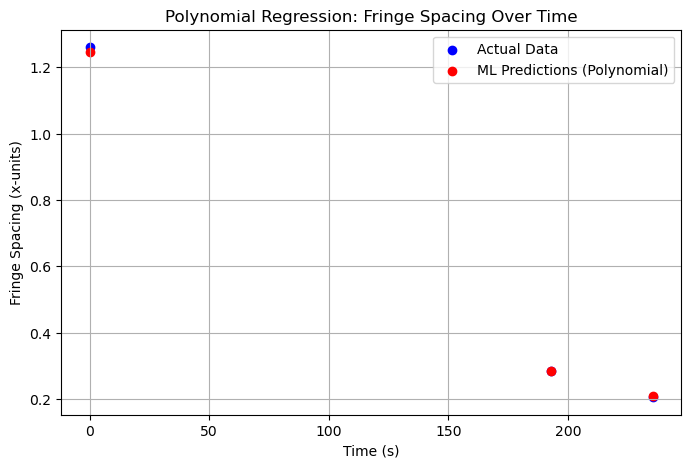

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------
# Prepare Data for ML (Polynomial Regression)
# ------------------------------
X = time_values.reshape(-1, 1)
Y = fringe_spacing_over_time

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Transform features to polynomial features (degree=3)
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# ------------------------------
# Train Polynomial Regression Model
# ------------------------------
model_poly = LinearRegression()
model_poly.fit(X_train_poly, Y_train)

# Predict and evaluate
Y_pred_poly = model_poly.predict(X_test_poly)
mse_poly = mean_squared_error(Y_test, Y_pred_poly)
r2_poly = r2_score(Y_test, Y_pred_poly)

print("Polynomial Regression Model Results:")
print(f"Mean Squared Error (MSE): {mse_poly:.6f}")
print(f"R-squared (R2) Score: {r2_poly:.6f}")

# ------------------------------
# Plot: Actual Data vs. Polynomial Regression Predictions
# ------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(X_test, Y_test, label="Actual Data", color="blue")
plt.scatter(X_test, Y_pred_poly, label="ML Predictions (Polynomial)", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Polynomial Regression: Fringe Spacing Over Time")
plt.legend()
plt.grid(True)
plt.show()


## Cell 8: Deep Learning – Neural Network Prediction of Fringe Spacing Over Time
This cell trains a simple feed-forward neural network (using Keras) on the same data, compares its performance to the polynomial regression, and plots the predictions.


C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Neural Network Model Results:
Mean Squared Error (MSE): 0.211819
R-squared (R2) Score: 0.078793


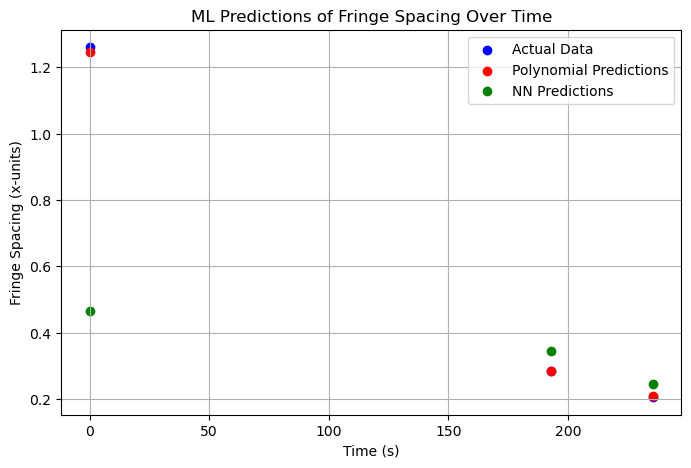

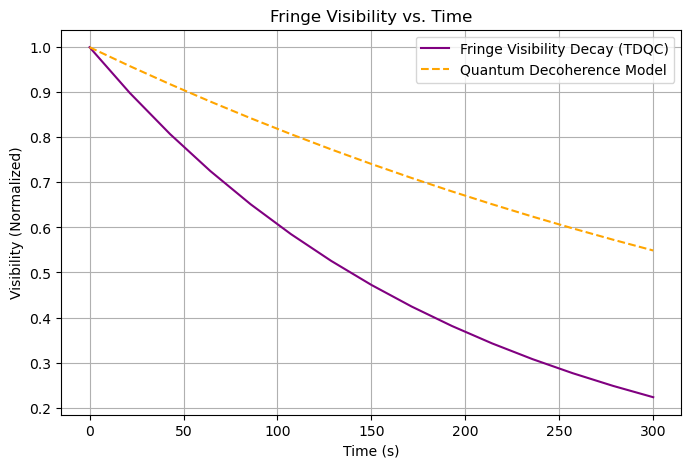

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# ------------------------------
# Prepare Data for Neural Network
# ------------------------------
X = time_values.reshape(-1, 1)
Y = fringe_spacing_over_time

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# ------------------------------
# Build and Train Neural Network Model
# ------------------------------
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])
model_nn.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
history = model_nn.fit(X_train, Y_train, epochs=500, verbose=0, validation_data=(X_test, Y_test))

# Predict and evaluate
Y_pred_nn = model_nn.predict(X_test)
mse_nn = mean_squared_error(Y_test, Y_pred_nn)
r2_nn = r2_score(Y_test, Y_pred_nn)

print("Neural Network Model Results:")
print(f"Mean Squared Error (MSE): {mse_nn:.6f}")
print(f"R-squared (R2) Score: {r2_nn:.6f}")

# ------------------------------
# Plot: Actual Data vs. NN and Polynomial Predictions
# ------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(X_test, Y_test, label="Actual Data", color="blue")
plt.scatter(X_test, Y_pred_poly, label="Polynomial Predictions", color="red")
plt.scatter(X_test, Y_pred_nn, label="NN Predictions", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("ML Predictions of Fringe Spacing Over Time")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Plot: Fringe Visibility vs. Time (for comparison)
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(time_values, fringe_visibility_over_time, label="Fringe Visibility Decay (TDQC)", color="purple")
plt.plot(time_values, decoherence_model, label="Quantum Decoherence Model", color="orange", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Visibility (Normalized)")
plt.title("Fringe Visibility vs. Time")
plt.legend()
plt.grid(True)
plt.show()




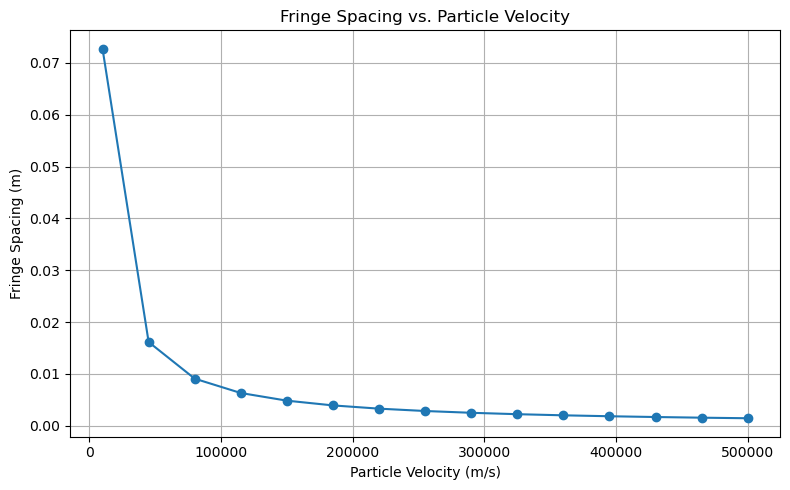

    Velocity (m/s)  de Broglie Wavelength (m)  Fringe Spacing (m)
0          10000.0               7.273326e-08            0.072733
1          45000.0               1.616295e-08            0.016163
2          80000.0               9.091658e-09            0.009092
3         115000.0               6.324631e-09            0.006325
4         150000.0               4.848884e-09            0.004849
5         185000.0               3.931528e-09            0.003932
6         220000.0               3.306057e-09            0.003306
7         255000.0               2.852285e-09            0.002852
8         290000.0               2.508043e-09            0.002508
9         325000.0               2.237946e-09            0.002238
10        360000.0               2.020368e-09            0.002020
11        395000.0               1.841348e-09            0.001841
12        430000.0               1.691471e-09            0.001691
13        465000.0               1.564156e-09            0.001564
14        

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Constants and Setup
# ------------------------------
h = 6.626e-34  # Planck's constant (J·s)
d = 1e-6       # Slit separation in meters (1 micrometer)
L = 1.0        # Distance from slits to screen in meters

# Define a range of particle velocities (m/s)
velocities = np.linspace(1e4, 5e5, 15)

# Assume a fixed particle mass (electron)
m = 9.11e-31  # kg

# ------------------------------
# Calculations
# ------------------------------
wavelengths = h / (m * velocities)                  # de Broglie wavelengths
fringe_spacings = wavelengths * L / d               # theoretical fringe spacings

# Create DataFrame
df_results = pd.DataFrame({
    'Velocity (m/s)': velocities,
    'de Broglie Wavelength (m)': wavelengths,
    'Fringe Spacing (m)': fringe_spacings
})

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(velocities, fringe_spacings, marker='o')
plt.xlabel('Particle Velocity (m/s)')
plt.ylabel('Fringe Spacing (m)')
plt.title('Fringe Spacing vs. Particle Velocity')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Output Data
# ------------------------------
print(df_results)


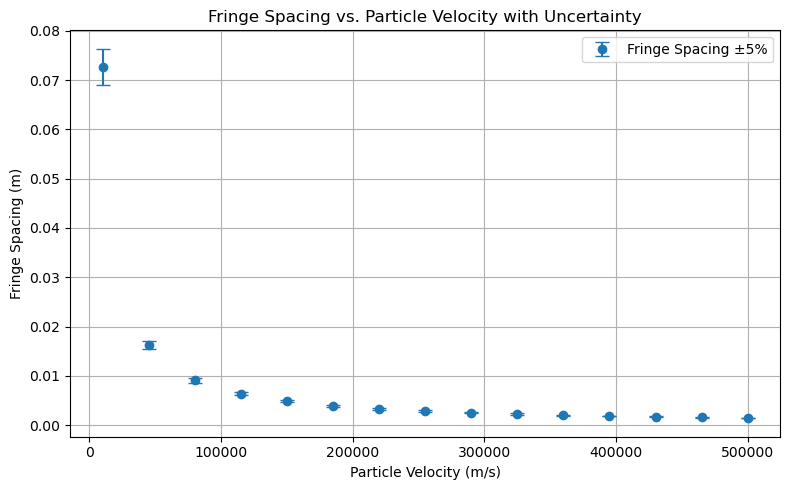

In [12]:
import matplotlib.pyplot as plt

# Simulated uncertainty for fringe spacing (for demonstration)
# Assuming ±5% uncertainty in fringe spacing due to measurement/peak detection variability
uncertainty = fringe_spacings * 0.05

# ------------------------------
# Plot with Error Bars (Uncertainty Quantification)
# ------------------------------
plt.figure(figsize=(8, 5))
plt.errorbar(velocities, fringe_spacings, yerr=uncertainty, fmt='o', capsize=5, label='Fringe Spacing ±5%')
plt.xlabel('Particle Velocity (m/s)')
plt.ylabel('Fringe Spacing (m)')
plt.title('Fringe Spacing vs. Particle Velocity with Uncertainty')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Simulated coherence decay data (replace with your real data if needed)
np.random.seed(42)
time = np.linspace(0, 300, 15)
true_lambda = 0.0077
A_true = 1.0
y_obs = A_true * np.exp(-true_lambda * time) + np.random.normal(0, 0.03, len(time))

# Bayesian model
with pm.Model() as model:
    λ = pm.HalfNormal("lambda", sigma=0.01)
    A = pm.Normal("A", mu=1.0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=0.05)
    mu = A * pm.math.exp(-λ * time)
    
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_obs)
    trace = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True)

# Summary & Posterior Plot
az.plot_posterior(trace, var_names=["lambda"], hdi_prob=0.95)
plt.show()

print(az.summary(trace, var_names=["lambda", "A"], round_to=6))


ModuleNotFoundError: No module named 'pymc'